In [3]:
setwd("/home/pa/Documents/github/doc_suomi/code")
source("utils.R")
source("data_cook.R")
library("markovchain")
cat(howto_data)

`summarise()` has grouped output by 'album_id', 'name'. You can override using the `.groups` argument.



How to use datasets (Personal library)
 
call    base()             for real values
call    z_scored()         for normalized
call    min_maxed()        for normalized2
call    upsampled_album()  for binded upsamplped albums
call    low_minmax()       for min-maxed low level
call    low_z()            for normalized low level
call    low_raw()          for raw  low level

# Markov Chain feature


## Idea 

Here I'm rebooting the previous Markov model. Instead of using a rank transformation of the features within each album, I simply encoded the feature of track $i+1$ as being higher or lower than the feature of track $i$. 

With this idea, I was hoping to pick up on very simple ordering patterns (e.g. tracks becoming increasingly louder), which should reflect on transition matrix patterns. Also, this encoding of the data picks up on larger patterns of transitions, if compared to the rank-order attempt. 

For instance, If a feature of track $i$ is set to "louder", it means that track $i-1$ was "quieter" than track $i$. Therefore, the transition matrix from one state to the other essentially tells us the probability of a sequence of 3 tracks from $i-1$ to $i+1$.


## Evaluation

After encoding each feature transition, I kept two versions of the same training set: 1) the original one, and 2) a permutated vearsion of each album. These two data sets were used to fit two distinct sets of transition matrices (one for each feature, and one for each data set).

Within the training data set (20% of the albums), I evaluated the likelyhood of the data under two different markov models (the one fitted on the original albums and the one fitted on the permutated album).

Mean log likelyhoods were separatelly calculated for each album, and error bars represent a measure of dispersion across all albums.

In [4]:
# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

Warning message in melt(data = log_likelihoods, measure.vars = c("empirical_valence", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(log_likelihoods). In the next version, this warning will become an error.”


feature,condition,log_likelihood,se
<chr>,<chr>,<dbl>,<dbl>
energy,empirical,-0.5799277,0.0034171199
energy,random,-0.6172480,0.0007631961
loudness,empirical,-0.5831564,0.0031378496
loudness,random,-0.6140933,0.0008727319
tempo,empirical,-0.5906169,0.0031513886
tempo,random,-0.6161933,0.0008221498
valence,empirical,-0.5854649,0.0033033404
valence,random,-0.6160719,0.0007998753


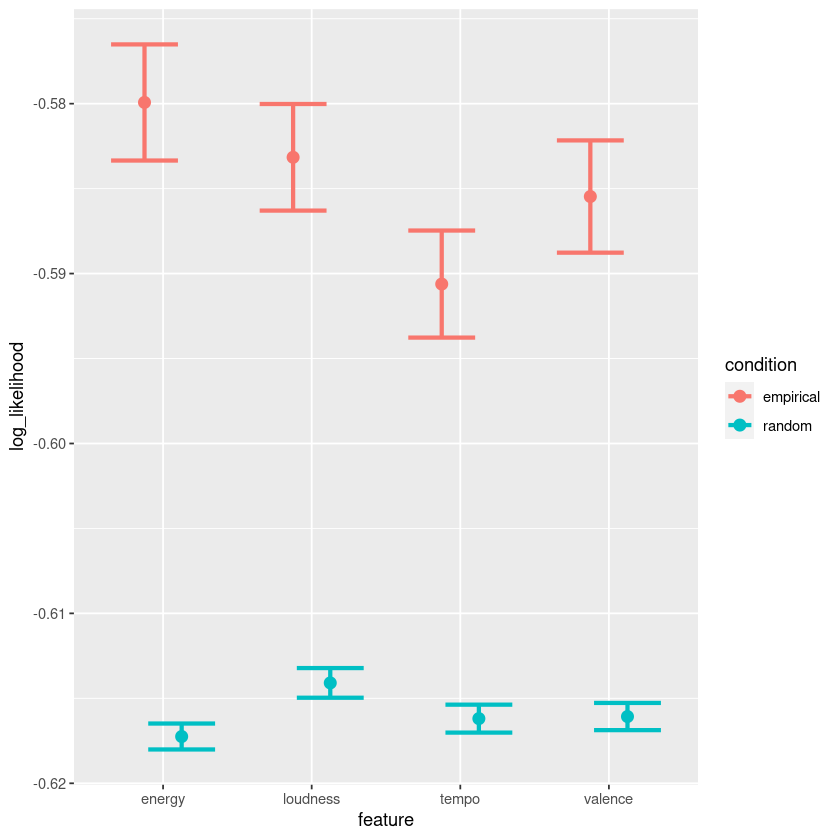

In [5]:
dt = base() %>% 
        group_by(album_id) %>%
        mutate(valence = greater(valence),
               energy = greater(energy),
               loudness = greater(loudness),
               tempo = greater(tempo))

dt = album_splitter(dt)


# split into traning and test data
dt_train  = dt[1:(length(dt)*0.8)]
dt_test   = dt[(length(dt)*0.8):length(dt)]

valence = c(); energy = c() ;loudness = c(); tempo = c()
rv = c(); re = c() ; rl = c(); rt = c()
valence_t = c(); energy_t = c() ;loudness_t = c(); tempo_t = c()

for(i in 1:length(dt_train)){
    valence[[i]]  <- c(as.character(dt_train[[i]]$valence))
    energy[[i]]   <- c(as.character(dt_train[[i]]$energy))
    loudness[[i]] <- c(as.character(dt_train[[i]]$loudness))
    tempo[[i]]    <- c(as.character(dt_train[[i]]$tempo))
}

for(i in 1:length(dt_train)){
    rv[[i]]  <- c("start", sample(as.character(dt_train[[i]]$valence[2:length(dt_train[[i]]$valence)]), replace = FALSE, size = length(dt_train[[i]]$valence)-1))
    re[[i]]   <- c("start", sample(as.character(dt_train[[i]]$energy[2:length(dt_train[[i]]$energy)]), replace = FALSE, size = length(dt_train[[i]]$energy)-1))
    rl[[i]] <- c("start", sample(as.character(dt_train[[i]]$loudness[2:length(dt_train[[i]]$loudness)]), replace = FALSE, size = length(dt_train[[i]]$loudness)-1))
    rt[[i]]    <- c("start", sample(as.character(dt_train[[i]]$tempo[2:length(dt_train[[i]]$tempo)]), replace = FALSE, size = length(dt_train[[i]]$tempo)-1))
}

for(i in 1:length(dt_test)){
    valence_t[[i]]  <- c(as.character(dt_test[[i]]$valence))
    energy_t[[i]]   <- c(as.character(dt_test[[i]]$energy))
    loudness_t[[i]] <- c(as.character(dt_test[[i]]$loudness))
    tempo_t[[i]]    <- c(as.character(dt_test[[i]]$tempo))
}

states = as.character(c("greater", "smaller", "start"))

# #Getting the transition
v = data.frame(markovchainFit(data = valence)$estimate@transitionMatrix)
e = data.frame(markovchainFit(data = energy)$estimate@transitionMatrix)
l = data.frame(markovchainFit(data = loudness)$estimate@transitionMatrix)
t = data.frame(markovchainFit(data = tempo)$estimate@transitionMatrix)

#creating the object
v <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(v)), byrow = TRUE, nrow = nrow(v)), name = "valence")
e <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(e)), byrow = TRUE, nrow = nrow(e)), name = "energy")
l <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(l)), byrow = TRUE, nrow = nrow(l)), name = "loudness")
t <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(t)), byrow = TRUE, nrow = nrow(t)), name = "tempo")

rv = data.frame(markovchainFit(data = rv)$estimate@transitionMatrix)
re = data.frame(markovchainFit(data = re)$estimate@transitionMatrix)
rl = data.frame(markovchainFit(data = rl)$estimate@transitionMatrix)
rt = data.frame(markovchainFit(data = rt)$estimate@transitionMatrix)

rv <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rv)), byrow = TRUE, nrow = nrow(v)), name = "rvalence")
re <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(re)), byrow = TRUE, nrow = nrow(e)), name = "renergy")
rl <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rl)), byrow = TRUE, nrow = nrow(l)), name = "rloudness")
rt <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rt)), byrow = TRUE, nrow = nrow(t)), name = "rtempo")

for(j in 1){
    v_ll <- c(); e_ll <- c(); l_ll <- c(); t_ll <- c()
    
    r_v <- c(); r_e <- c(); r_l <- c(); r_t <- c()

    for(i in 1:length(valence_t)){
        v_ll[[i]] <- mll(v, valence_t[[i]])
        e_ll[[i]] <- mll(e, energy_t[[i]])
        l_ll[[i]] <- mll(l, loudness_t[[i]])
        t_ll[[i]] <- mll(t, tempo_t[[i]])
        
        r_v[[i]] <- mll(rv, valence_t[[i]])
        r_e[[i]] <- mll(re, energy_t[[i]])
        r_l[[i]] <- mll(rl, loudness_t[[i]])
        r_t[[i]] <- mll(rt, tempo_t[[i]])
        }
    }

log_likelihoods <- 
    data.frame(empirical_valence = unlist(v_ll),
               empirical_energy = unlist(e_ll),
               empirical_loudness = unlist(l_ll),
               empirical_tempo = unlist(t_ll),
               
               random_valence = unlist(r_v),
               random_energy = unlist(r_e),
               random_loudness = unlist(r_l),
               random_tempo = unlist(r_t)
              )

ll <-
    melt(data = log_likelihoods, 
        measure.vars = c('empirical_valence',
                         'empirical_energy',
                         'empirical_loudness',
                         'empirical_tempo',
                         'random_valence',
                         'random_energy',
                         'random_loudness',
                         'random_tempo')
    )

ll<- 
    tidyr::separate(ll, 
         variable, 
         c("condition", "feature"), 
         "_")

teste2 <- plyr::ddply(ll, c('feature', 'condition'), plyr::summarise,
                           log_likelihood = mean(value),
                           se = sd(value)/sqrt(length(value))
)
teste2
ggplot(teste2, aes(x=feature, y=log_likelihood, color = condition)) +
    geom_errorbar(size = 1.2, aes(ymin=log_likelihood-se, ymax=log_likelihood+se), position=position_dodge(0.5)) +
    geom_point(size = 3, position=position_dodge(0.5), fill = 'black')

In [6]:
print("Valence"); v@transitionMatrix; 
print("Energy"); e@transitionMatrix; 
print("Loudness"); l@transitionMatrix; 
print("Tempo"); t@transitionMatrix

[1] "Valence"


,greater,smaller,start
greater,0.3205376,0.6794624,0
smaller,0.6677269,0.3322731,0
start,0.5336611,0.4663389,0


[1] "Energy"


,greater,smaller,start
greater,0.3118086,0.6881914,0
smaller,0.6616254,0.3383746,0
start,0.5075643,0.4924357,0


[1] "Loudness"


,greater,smaller,start
greater,0.3223561,0.6776439,0
smaller,0.6515744,0.3484256,0
start,0.5279879,0.4720121,0


[1] "Tempo"


,greater,smaller,start
greater,0.3328422,0.6671578,0
smaller,0.6619533,0.3380467,0
start,0.5075643,0.4924357,0


In [7]:
print("Valence"); rv@transitionMatrix; 
print("Energy"); re@transitionMatrix; 
print("Loudness"); rl@transitionMatrix; 
print("Tempo"); rt@transitionMatrix

[1] "Valence"


,greater,smaller,start
greater,0.4668268,0.5331732,0
smaller,0.5277928,0.4722072,0
start,0.4984871,0.5015129,0


[1] "Energy"


,greater,smaller,start
greater,0.4637097,0.5362903,0
smaller,0.5154295,0.4845705,0
start,0.4973525,0.5026475,0


[1] "Loudness"


,greater,smaller,start
greater,0.4595637,0.5404363,0
smaller,0.5268686,0.4731314,0
start,0.4780635,0.5219365,0


[1] "Tempo"


,greater,smaller,start
greater,0.4668530,0.5331470,0
smaller,0.5319954,0.4680046,0
start,0.4897882,0.5102118,0


# Markov chains and track probability

## Following idea

Even though the binary encoding of the data seems simple and naive, I think that we have some potential here, and this potential might relate to the interaction of transitions between each feature.

If take into account the transition probability of our 4 features, we should find, for instance, that the likelyhood of transitioning from track_number_1 to track_number_2 is generally the highest - or one of the highest, if compared to the other tracks within the album.

With that, we should be able to narrow down the best candidates for track $i+1$, given the states of track $i$. I ilustrate this idea below. 

The column named "track_2_candidates" indicates each track's likelyhood of appearing immediately after track 1. We see that tracks 2, 4 and 6 are the best candidates for following (with tied likelyhoods). The column named track_3_can says that, in fact, track 3 has the highest likelyhood of following track 2.

In [32]:
#Pega todas as probabilidades de transicao entre o track origin e os proximos tracks dos albums
probs = function(x, object, track_origin){
    tprobs = c()
    for(i in 1:(length(x))){
        if(i <= track_origin){
            tprobs[[i]] = 0
        } 
        if(track_origin != i){
            tprobs = c(tprobs, transitionProbability(object, x[[track_origin]], x[[i]]))
        }
    #print(i == track_origin)    
    }
    
    return(unlist(tprobs))
}

### Below is just for visualization
i = 100
dt_test[[i]]$track_2_candidates = c(probs(dt_test[[i]]$valence, v, 1)*probs(dt_test[[i]]$energy, e, 1)*probs(dt_test[[i]]$loudness, l, 1)*probs(dt_test[[i]]$tempo, t, 1))
dt_test[[i]]$track_3_can = c(probs(dt_test[[i]]$valence, v, 2)*probs(dt_test[[i]]$energy, e, 2)*probs(dt_test[[i]]$loudness, l, 2)*probs(dt_test[[i]]$tempo, t, 2))
dt_test[[i]]$track_4_can = c(probs(dt_test[[i]]$valence, v, 3)*probs(dt_test[[i]]$energy, e, 3)*probs(dt_test[[i]]$loudness, l, 3)*probs(dt_test[[i]]$tempo, t, 3))
dt_test[[i]]$track_5_can = c(probs(dt_test[[i]]$valence, v, 4)*probs(dt_test[[i]]$energy, e, 4)*probs(dt_test[[i]]$loudness, l, 4)*probs(dt_test[[i]]$tempo, t, 4))
dt_test[[i]]$track_6_can = c(probs(dt_test[[i]]$valence, v, 5)*probs(dt_test[[i]]$energy, e, 5)*probs(dt_test[[i]]$loudness, l, 5)*probs(dt_test[[i]]$tempo, t, 5))    

In [33]:
dt_test[[i]] %>% select(track_number, track_2_candidates, track_3_can, track_4_can, track_5_can, track_6_can)

Adding missing grouping variables: `album_id`



album_id,track_number,track_2_candidates,track_3_can,track_4_can,track_5_can,track_6_can
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6IGVK6UkTCPWIBEnUoOtBK,1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
6IGVK6UkTCPWIBEnUoOtBK,2,0.07042553,0.00000000,0.00000000,0.00000000,0.00000000
6IGVK6UkTCPWIBEnUoOtBK,3,0.05337696,0.10394253,0.00000000,0.00000000,0.00000000
6IGVK6UkTCPWIBEnUoOtBK,4,0.07042553,0.01163726,0.09745137,0.00000000,0.00000000
6IGVK6UkTCPWIBEnUoOtBK,5,0.05337696,0.10394253,0.01324280,0.10394253,0.00000000
6IGVK6UkTCPWIBEnUoOtBK,6,0.06343190,0.04823384,0.09481972,0.04823384,0.09481972
6IGVK6UkTCPWIBEnUoOtBK,7,0.06832641,0.02332604,0.04976652,0.02332604,0.04976652


A different example from a different album

![](/home/pasoneto/Documents/github/doc_suomi/code/analysis/data2.png)


## Generalizing to the whole test data set

Now I'm veryfing the frequency with which track $i+1$ is identifyed as the most likely track to follow track $i$.
Results are displayed below.

*Note: these are still exploratory and we have some limitations, such as the issue of imbalanced album lengths, as well as the fact that the first track of each album doesn't have a comparative feature.

In [9]:
for(i in 1:length(dt_test)){
    dt_test[[i]]$track_2_candidates = c(probs(dt_test[[i]]$valence, v, 1)*probs(dt_test[[i]]$energy, e, 1)*probs(dt_test[[i]]$loudness, l, 1)*probs(dt_test[[i]]$tempo, t, 1))
    dt_test[[i]]$track_3_can = c(probs(dt_test[[i]]$valence, v, 2)*probs(dt_test[[i]]$energy, e, 2)*probs(dt_test[[i]]$loudness, l, 2)*probs(dt_test[[i]]$tempo, t, 2))
    dt_test[[i]]$track_4_can = c(probs(dt_test[[i]]$valence, v, 3)*probs(dt_test[[i]]$energy, e, 3)*probs(dt_test[[i]]$loudness, l, 3)*probs(dt_test[[i]]$tempo, t, 3))
    dt_test[[i]]$track_5_can = c(probs(dt_test[[i]]$valence, v, 4)*probs(dt_test[[i]]$energy, e, 4)*probs(dt_test[[i]]$loudness, l, 4)*probs(dt_test[[i]]$tempo, t, 4))
    dt_test[[i]]$track_6_can = c(probs(dt_test[[i]]$valence, v, 5)*probs(dt_test[[i]]$energy, e, 5)*probs(dt_test[[i]]$loudness, l, 5)*probs(dt_test[[i]]$tempo, t, 5))
    dt_test[[i]]$track_7_can = c(probs(dt_test[[i]]$valence, v, 6)*probs(dt_test[[i]]$energy, e, 6)*probs(dt_test[[i]]$loudness, l, 6)*probs(dt_test[[i]]$tempo, t, 6))    
}

In [10]:
final = dplyr::bind_rows(dt_test)

`summarise()` has grouped output by 'album_id'. You can override using the `.groups` argument.



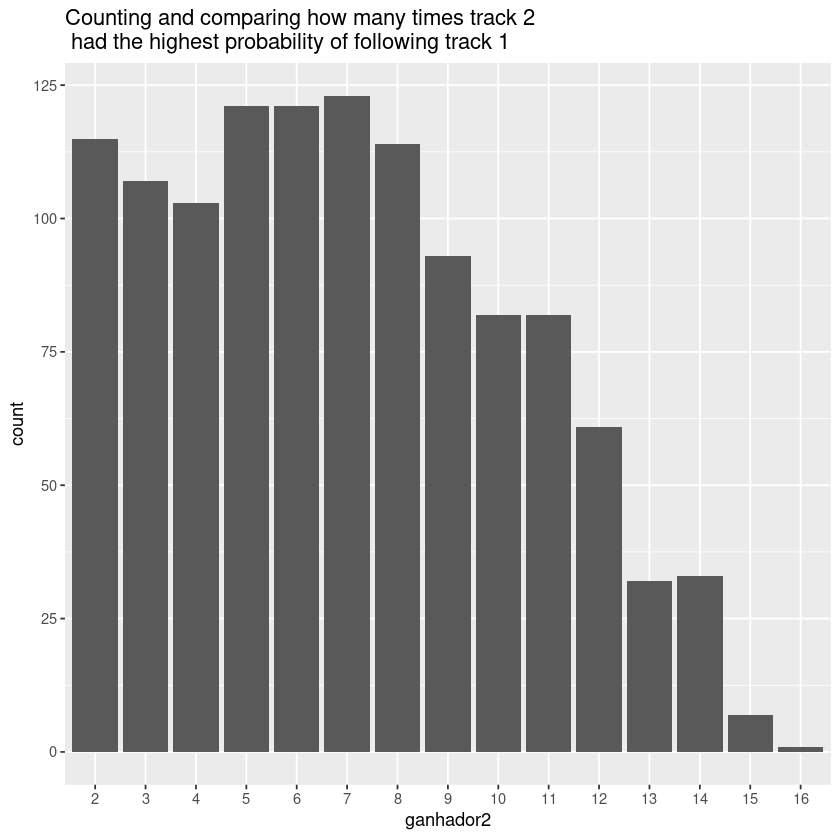

In [11]:
sorter = function(data){ tn = which(data == max(data))}
###############################
final %>% 
    group_by(album_id) %>%
    summarise(ganhador2 = as.character(track_number[sorter(track_2_candidates)])) -> g2

g2$ganhador2 <- factor(g2$ganhador2,levels = as.character(c(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)))
g2 %>%
    ggplot(aes(ganhador2))+
           geom_bar(stat="count") + ggtitle("Counting and comparing how many times track 2 \n had the highest probability of following track 1")

`summarise()` has grouped output by 'album_id'. You can override using the `.groups` argument.



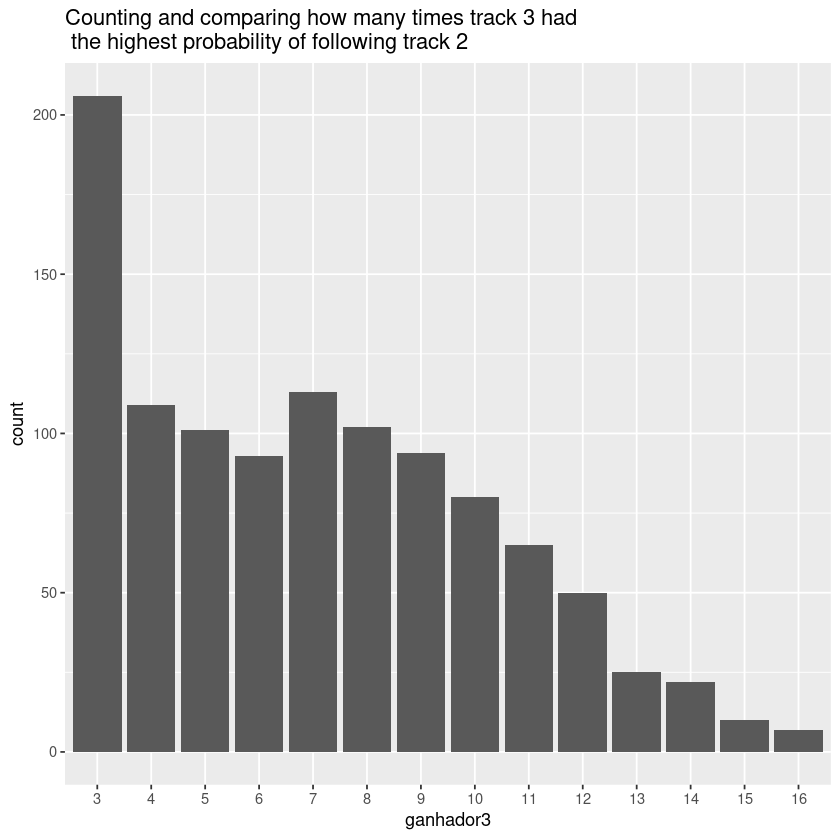

In [12]:
###############################
final %>% 
    group_by(album_id) %>%
    summarise(ganhador3 = as.character(track_number[sorter(track_3_can)])) -> g3

g3$ganhador3 <- factor(g3$ganhador3,levels = as.character(c(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)))
g3 %>%
    ggplot(aes(ganhador3))+
           geom_bar(stat="count") + ggtitle("Counting and comparing how many times track 3 had \n the highest probability of following track 2")

`summarise()` has grouped output by 'album_id'. You can override using the `.groups` argument.



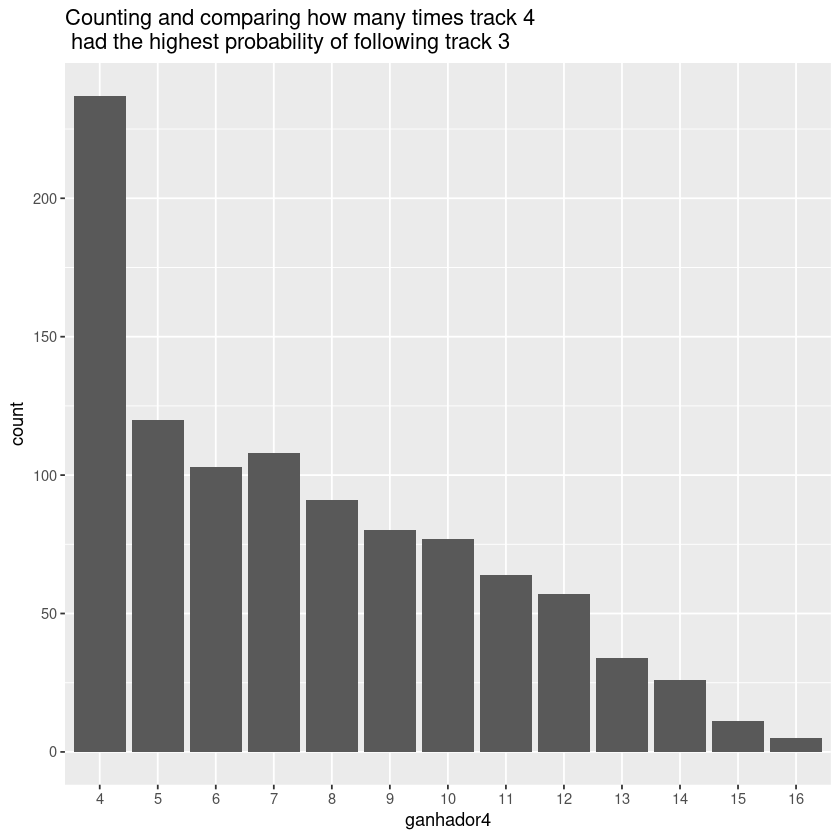

In [13]:
###############################
final %>% 
    group_by(album_id) %>%
    summarise(ganhador4 = as.character(track_number[sorter(track_4_can)])) -> g4

g4$ganhador4 <- factor(g4$ganhador4,levels = as.character(c(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)))
g4 %>%
    ggplot(aes(ganhador4))+
           geom_bar(stat="count") + ggtitle("Counting and comparing how many times track 4 \n had the highest probability of following track 3")

`summarise()` has grouped output by 'album_id'. You can override using the `.groups` argument.



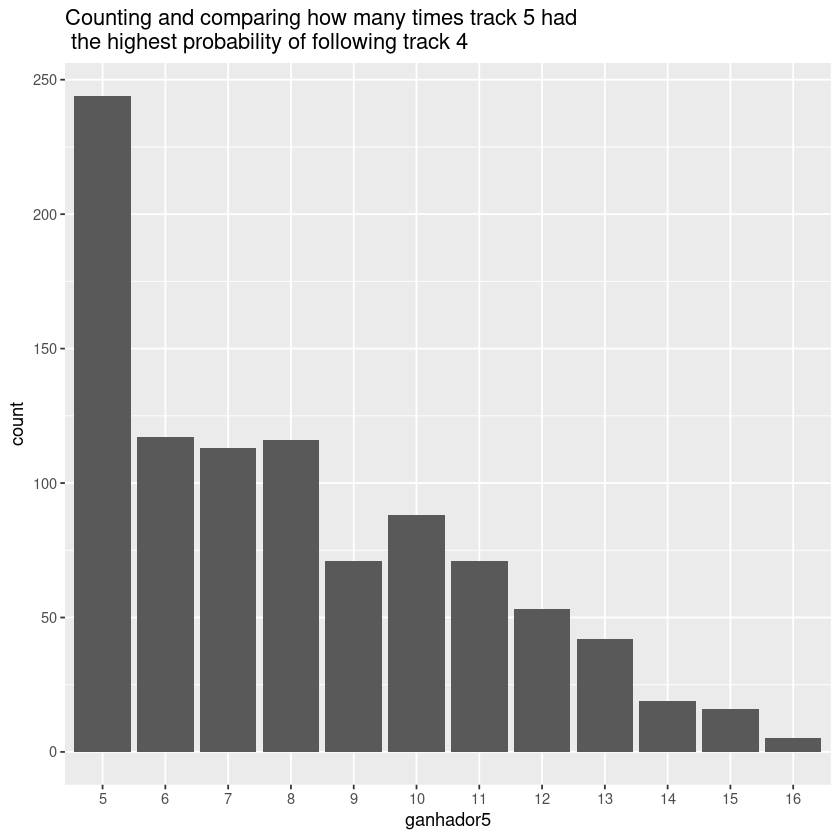

In [14]:
###############################
final %>% 
    group_by(album_id) %>%
    summarise(ganhador5 = as.character(track_number[sorter(track_5_can)])) -> g5

g5$ganhador5 <- factor(g5$ganhador5,levels = as.character(c(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)))
g5 %>%
    ggplot(aes(ganhador5))+
           geom_bar(stat="count") + ggtitle("Counting and comparing how many times track 5 had \n the highest probability of following track 4")

`summarise()` has grouped output by 'album_id'. You can override using the `.groups` argument.



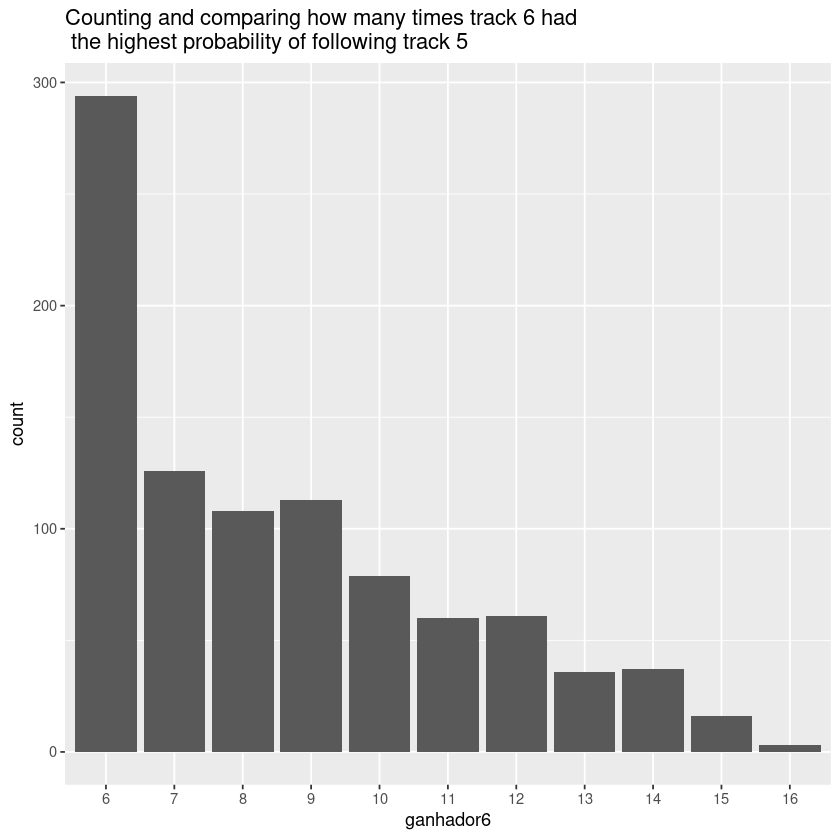

In [15]:
###############################
final %>% 
    group_by(album_id) %>%
    summarise(ganhador6 = as.character(track_number[sorter(track_6_can)])) -> g6

g6$ganhador6 <- factor(g6$ganhador6,levels = as.character(c(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)))
g6 %>%
    ggplot(aes(ganhador6))+
           geom_bar(stat="count") +
           geom_bar(stat="count") + ggtitle("Counting and comparing how many times track 6 had \n the highest probability of following track 5")
